In [0]:
from numpy import array
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Activation, Reshape, Masking
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pydot
import graphviz
from midiScripts.full_piano_roll_converter import FullPianoRollConverter
import base

%load_ext autoreload
%autoreload 2

In [1]:
# pip install --upgrade tensorflow-gpu==2.0 # run if needed

In [0]:
fprc = FullPianoRollConverter()

In [0]:
# updatable plot for live loss value observation
# a minimal example (sort of)

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
#         self.accuracy.append(logs.get('binary_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
#         plt.plot(self.x, self.accuracy, label="accuracy")
        plt.legend()
        plt.show();
        
plot = PlotLosses()

In [0]:
class Autoencoder():
    
    def __init__(self, chords_len):
        self.chords_len = chords_len # length of one-hot encoded vector representing one note
        self.seq_window = 16 # length of notes in one music sample
        self.lstm_state = 4048 # length of wide lstm cells output
    
        self.encoder, self.decoder, self.model = self.autoencoder_model()
        
    def autoencoder_model(self):
    
        # # define encoder
        enc_inputs1 = Input(shape=(None, 3, self.chords_len), name="encoder_input")
        enc_inputs2 = Reshape((-1, self.chords_len * 3), input_shape=(None, 3, self.chords_len))(enc_inputs1)
        enc_output = LSTM(self.lstm_state, return_sequences = False, return_state = False, name="lstm_1")(enc_inputs2)

        encoder = Model(enc_inputs1, enc_output, name="encoder")

        # define decoder
        dec_inputs = Input(shape=encoder.output.shape[1:], name="decoder_input")
        dec_inputs_exp = tf.expand_dims(dec_inputs, axis=1, name="expand_dims")
        dec_repeated = tf.tile(dec_inputs_exp, [1, tf.shape(enc_inputs1)[1], 1], name="tile")
        dec_lstm = LSTM(self.lstm_state, return_sequences=True, name="lstm_2")(dec_repeated)
        play_output = TimeDistributed(Dense(self.chords_len, activation = 'sigmoid'), name="play_output")(dec_lstm)
        repeat_output = TimeDistributed(Dense(self.chords_len, activation = 'sigmoid'), name="repeat_output")(dec_lstm)
        volume_output = TimeDistributed(Dense(self.chords_len, activation = 'sigmoid'), name="volume_output")(dec_lstm)
        
        concat_output = tf.stack([play_output, repeat_output, volume_output], axis=-2, name="concatenated_output")
        
        decoder = Model(inputs=[dec_inputs, enc_inputs1], outputs=concat_output, name="decoder")
        
        model_encoded = encoder(enc_inputs1)
        model_decoded = decoder([model_encoded, enc_inputs1])
        model = Model(enc_inputs1, outputs=model_decoded, name="autoencoder")
        
        return encoder, decoder, model

    def load_my_model(self, model_weights):
        # load previously saved weights to the model
        self.model.load_weights(model_weights)


In [0]:
# set file from which you want to load weights for your model, or where you want to save weights durring nn training
# current_model = 'models/LSTMSeparateEncoder-Decoder_20_01_19_H1500_pianoRoll_final_2048.h5'

In [8]:
autoencoder = Autoencoder(len(fprc))

Tensor("concatenated_output:0", shape=(None, None, 3, 89), dtype=float32)


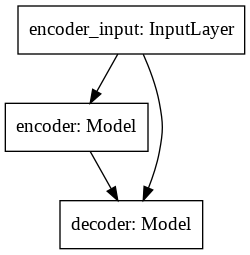

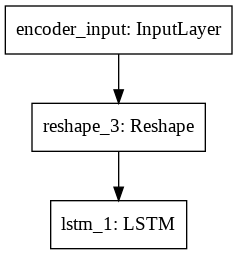

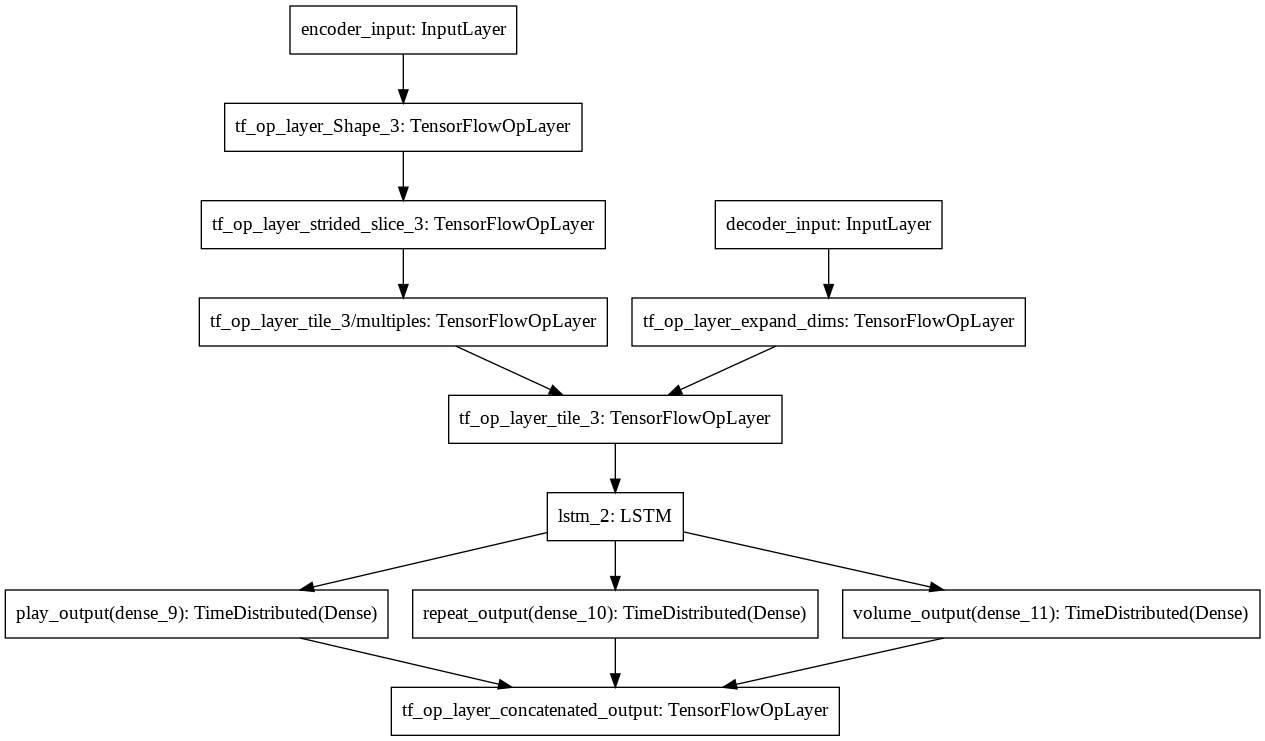

In [0]:
from IPython.display import display 
display(plot_model(autoencoder.model, to_file='model.png'))
display(plot_model(autoencoder.encoder, to_file='encoder.png'))
display(plot_model(autoencoder.decoder, to_file='decoder.png'))

In [2]:
autoencoder.decoder.summary()

In [ ]:
current_model = 'LSTMAutoencoder_loss0_19181.h5'

In [0]:
# autoencoder.load_my_model(current_model)
(autoencoder.model).load_weights(current_model)

In [0]:
def my_loss(y_true, y_pred):
    y_true_play, y_true_repeat, y_true_volume = tf.split(y_true, 3, axis=-2)
    y_pred_play, y_pred_repeat, y_pred_volume = tf.split(y_pred, 3, axis=-2)
    
    y_true_play, y_true_repeat, y_true_volume = (tf.squeeze(y_true_play, axis=-2),
                                                tf.squeeze(y_true_repeat, axis=-2),
                                                tf.squeeze(y_true_volume, axis=-2))
            
    y_pred_play, y_pred_repeat, y_pred_volume = (tf.squeeze(y_pred_play, axis=-2),
                                                tf.squeeze(y_pred_repeat, axis=-2),
                                                tf.squeeze(y_pred_volume, axis=-2))
    
    play_loss   = tf.reduce_sum(              K.binary_crossentropy(y_true_play,   y_pred_play),    axis=-1)
    repeat_loss = tf.reduce_sum(y_true_play * K.binary_crossentropy(y_true_repeat, y_pred_repeat),  axis=-1)
    volume_loss = tf.reduce_sum(y_true_play * tf.square(tf.subtract(y_true_volume, y_pred_volume)), axis=-1)
    
    return tf.reduce_mean(play_loss + repeat_loss + volume_loss)

In [0]:
# set optimizer with a given learning rate (lr)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [0]:
autoencoder.model.compile(optimizer=optimizer, 
                          loss=my_loss,
                          experimental_run_tf_function=False
                          )

In [0]:
mc = ModelCheckpoint(current_model, monitor='loss', mode='min', verbose=1, save_best_only=True)

In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [20]:
# base.get_training_data_dir()
x_dataset = tf.data.Dataset.from_generator(lambda:  fprc.samples_generator_for_nn_training(base.get_training_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape( [None, 3, len(fprc)]))
y_dataset = tf.data.Dataset.from_generator(lambda:  fprc.samples_generator_for_nn_training(base.get_training_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape([None, 3, len(fprc)]))

x_dataset = x_dataset.padded_batch(256, padded_shapes = ([None, 3, len(fprc)]))
y_dataset = y_dataset.padded_batch(256, padded_shapes = ([None, 3, len(fprc)]))

data_x_y = tf.data.Dataset.zip((x_dataset, y_dataset))

x_validate = tf.data.Dataset.from_generator(lambda: fprc.samples_generator_for_nn_training(base.get_training_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape([None, 3, len(fprc)]))
y_validate = tf.data.Dataset.from_generator(lambda: fprc.samples_generator_for_nn_training(base.get_training_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape([None, 3, len(fprc)]))

x_validate = x_validate.padded_batch(256, padded_shapes = tf.TensorShape([None, 3, len(fprc)]))
y_validate = y_validate.padded_batch(256, padded_shapes = tf.TensorShape([None, 3, len(fprc)]))

val_x_y = tf.data.Dataset.zip((x_validate, y_validate))

<DatasetV1Adapter shapes: (None, None, 3, 89), types: tf.float32>


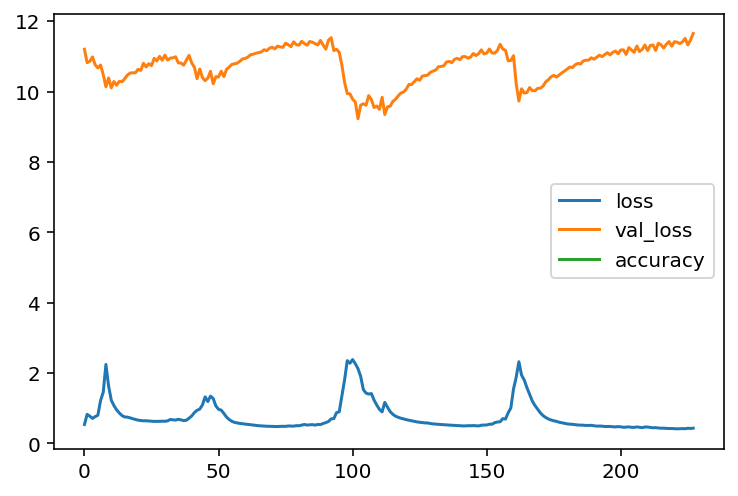


Epoch 00228: loss did not improve from 0.41590
16/16 [==============================] - 122s 8s/step - loss: 0.4266 - val_loss: 11.6535
Epoch 229/20000


In [0]:
# fit model
history = autoencoder.model.fit(data_x_y,
                                epochs=20000,
                                validation_data = val_x_y,
                                verbose=1,
                                callbacks =[plot, mc]
                                )

In [0]:
# for testing purposes
for value in x_dataset.take(100):
  # print(value)
  print(value.shape)

(128, 70, 3, 89)
(128, 60, 3, 89)
(128, 68, 3, 89)
(128, 50, 3, 89)
(128, 62, 3, 89)
(128, 70, 3, 89)
(128, 68, 3, 89)
(104, 68, 3, 89)
